# Práctica 2

In [13]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

import colorsys
import imageio
from skimage import exposure

# Default image path
img_path = "../img"

# Matplotlib plot size
plt.rcParams['figure.figsize'] = (15,15)

# Ignore all wanings
# TODO: Remove warnings

### Funciones utilizadas a lo largo de práctica

Para realizar la práctica, fue elegido el espacio de color **HSV**, en vez de **HSI**, el cual fue visto en clase. La deicisión se basó en que ya existe una librería de Python, *colorsys*, la cual posee la conversión de RGB a HSV, y viceversa implementada y validada.

La principal diferencia entre ambos espacios radica en la dimensión que representa la luminosidad de la imágen, en estos caso, **V**, o valor, e **I**, o intensidad. 

En el caso de HSV, la misma se computa como:

$\begin{align}
max(r,g,b)
\end{align}$

Por otro lado, en HSI se compua como:

$\begin{align}
\frac{r+g+b}{3}
\end{align}$

In [14]:
# Image helpers

def readImageAsRGB(routeToImage):
    """ 
        Loads an image, compress its values to the [0,1] range, and drop alpha channel 
    """
    img = imageio.imread(routeToImage)
    # Make image value rangeo from [0,255] to [0,1]
    img = img/255
    # Drop alpha channel
    img = img[:,:,(0,1,2)]
    return img

def scaleSaturation(img, c):
    """ 
        Scale saturation channel (channel 1 of (0,1,2)) by a constant c.
        The operation is not permormed in place, so a copy of the scaled 
        image is returned.
    """
    # TODO: Add clipping?
    copy = img.copy()
    copy[:,:,1] = copy[:,:,1] * c
    return copy

In [15]:
# Plot helpers

def show(ax, img, title = None):
    """
        Helper used to plot an image in a given axis, and adding an optional title
    """
    ax.imshow(img)
    ax.axis("off")
    if title is not None:
        ax.set_title(title)
        
def RGBHistogram(ax, img):
    """
        Plots an histogram for each channel in img, being img an RGB image.
        The channel's histograms are each one plotted on top of each other.
    """
    ax.hist(np.clip(img[:,:,0] * 256, 0, 255).ravel(),bins=256, histtype="step", color="r", density=True)
    ax.hist(np.clip(img[:,:,1] * 256, 0, 255).ravel(),bins=256, histtype="step", color="g", density=True)
    ax.hist(np.clip(img[:,:,2] * 256, 0, 255).ravel(),bins=256, histtype="step", color="b", density=True)
    ax.set_xlim((0,255))

### 1) Realce de la saturación

#### a) Multiplicar por una constante c > 1 cada pixel en el plano de la saturación. Ver que esto aumenta la intensidad aparente. Si c < 1 ver que reduce la intensidad del color.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


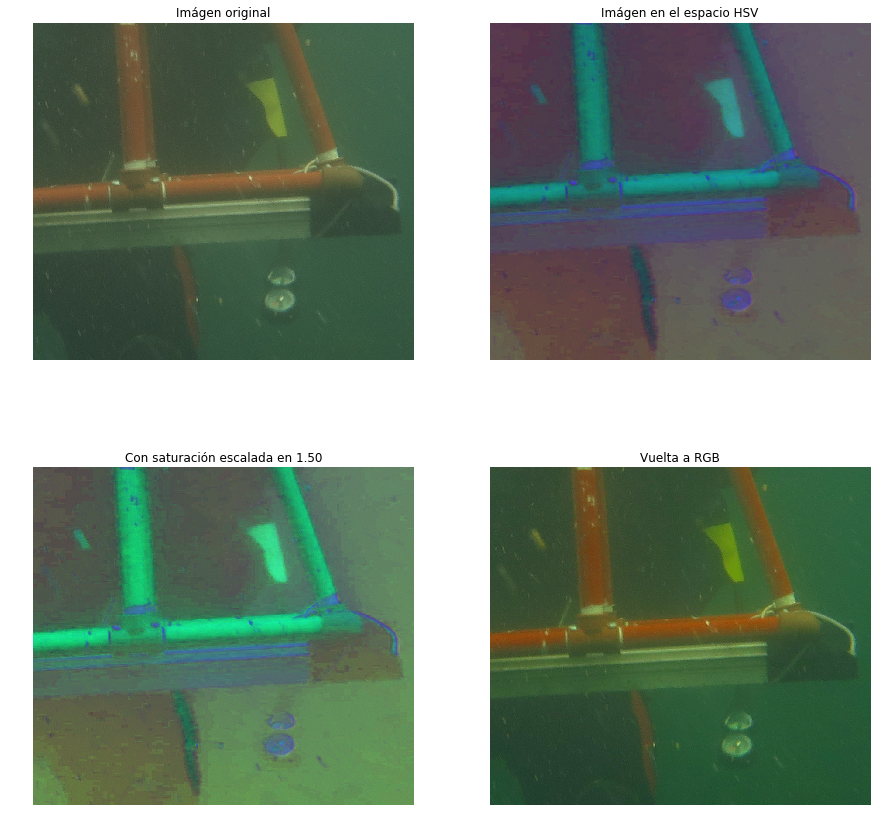

In [16]:
img = readImageAsRGB(img_path + "/ImagenesColor/1907xx.png")
imgAsHSV = colors.rgb_to_hsv(img)
    
saturationScale = 1.5
imgAsHSVWithScaledSaturation = scaleSaturation(imgAsHSV, saturationScale)
imgBackToRGB = colors.hsv_to_rgb(imgAsHSVWithScaledSaturation)

fig, ax = plt.subplots(nrows=2, ncols=2)
show(ax[0,0], img, title = "Imágen original")
show(ax[0,1], imgAsHSV, title = "Imágen en el espacio HSV")
show(ax[1,0], imgAsHSVWithScaledSaturation, title = "Con saturación escalada en %.2f" % (saturationScale))
show(ax[1,1], imgBackToRGB , title = "Vuelta a RGB")

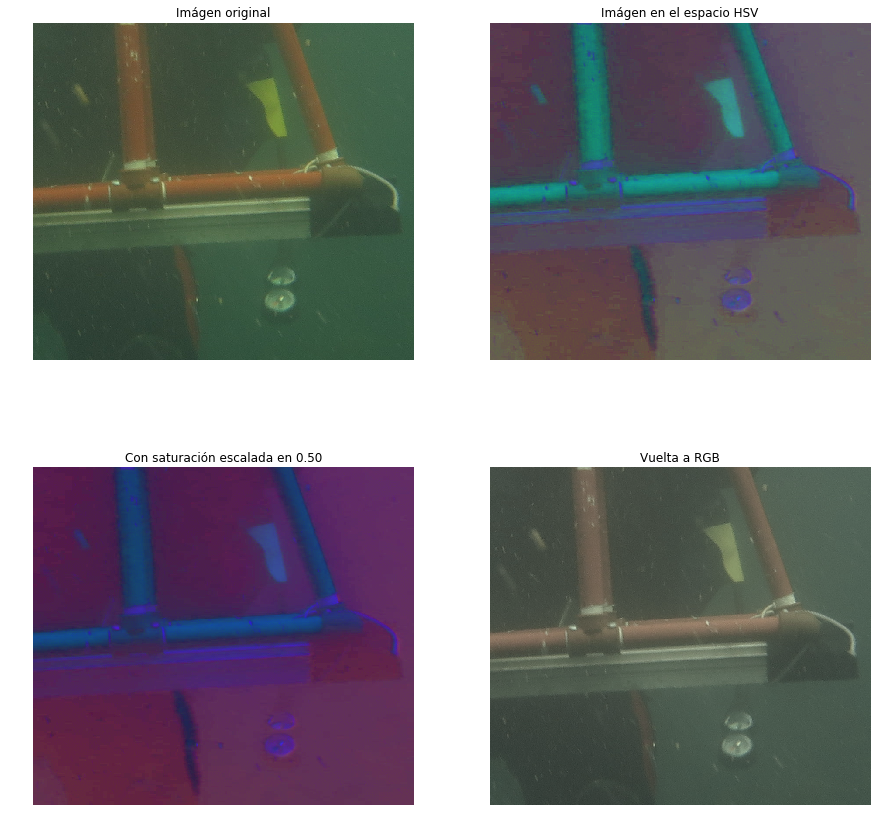

In [17]:
saturationScale = 0.5
imgAsHSVWithScaledSaturation = scaleSaturation(imgAsHSV, saturationScale)
imgBackToRGB = colors.hsv_to_rgb(imgAsHSVWithScaledSaturation)

fig, ax = plt.subplots(nrows=2, ncols=2)
show(ax[0,0], img, title = "Imágen original")
show(ax[0,1], imgAsHSV, title = "Imágen en el espacio HSV")
show(ax[1,0], imgAsHSVWithScaledSaturation, title = "Con saturación escalada en %.2f" % (saturationScale))
show(ax[1,1], imgBackToRGB , title = "Vuelta a RGB")

#### b) Realizar diferentes transformaciones lineales y no lineales al canal de saturación y ver el balance de colores.

La transformación (no lineal) aplicada al canal de saturación fue una corrección logartimica del mismo (*logarithmic correction*), es decir: 

$O = gain * log( 1 + I )$

Con $I$ el valor de saturación de un pixel, y $gain$, la intensidad de la transformación realizada.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


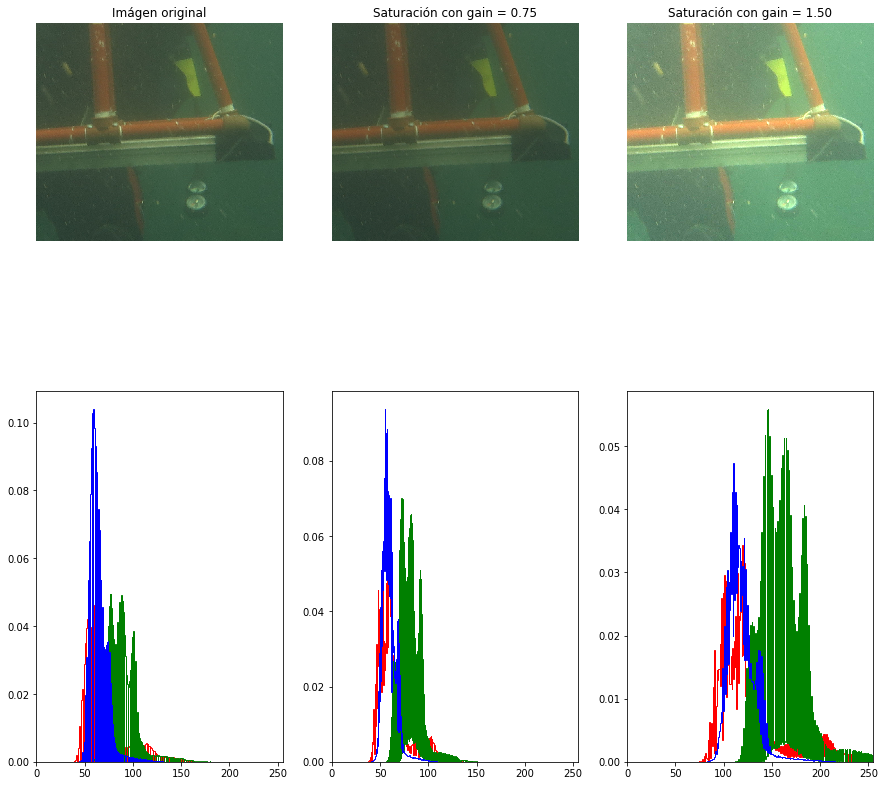

In [18]:
gain_1 = 0.75
gain_2 = 1.5

def applyLogTransformToSaturation(imgAsHSV, gain):
    """
        Apply a log transformation to the saturation (S) channel on a given image.
        imgAsHSV should be an image in the HSV color space.
    """
    imageWithLogAdjustmentInSaturaion = imgAsHSV.copy()
    imageWithLogAdjustmentInSaturaion[:,:,2] = exposure.adjust_log(imageWithLogAdjustmentInSaturaion[:,:,2], gain=gain)
    imgBackToRGB = colors.hsv_to_rgb(imageWithLogAdjustmentInSaturaion)
    return imgBackToRGB

firstGainCorrectedImage = applyLogTransformToSaturation(imgAsHSV, gain_1)
secondGainCorrectedImage = applyLogTransformToSaturation(imgAsHSV, gain_2)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,15))

show(ax[0,0], img, title="Imágen original")
RGBHistogram(ax[1,0], img)

show(ax[0,1], firstGainCorrectedImage, title="Saturación con gain = %.2f" % (gain_1))
RGBHistogram(ax[1,1], firstGainCorrectedImage)

show(ax[0,2], secondGainCorrectedImage, title="Saturación con gain = %.2f" % (gain_2))
RGBHistogram(ax[1,2], secondGainCorrectedImage)

### 2) Alteración del Hue

#### a) Sumar la constante c a los valores del canal H y ver el efecto en los colores cuando c es muy chico y qué sucede cuando c es muy grande.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


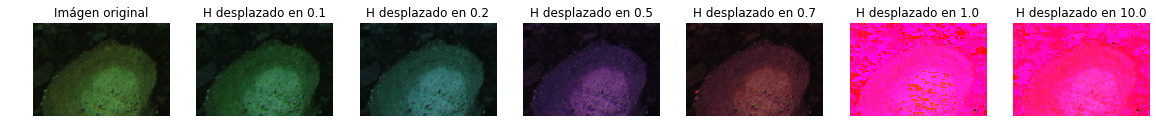

In [19]:
img = imageio.imread("../img/imagenesColor/1892xx.png")[:,:,(0,1,2)] / 255
img = colors.rgb_to_hsv(img)
differentCValues = [.1, .2, .5 , .7, 1, 10]

fig, ax = plt.subplots(nrows=1, ncols=1 + len(differentCValues), figsize=(20,20))

show(ax[0], colors.hsv_to_rgb(img), title="Imágen original")
for i, c in enumerate(differentCValues):
    imageWithHueDisplaced = img.copy()
    imageWithHueDisplaced[:, :, 0] = imageWithHueDisplaced[:, :, 0] + c
    # print("Min: %.2f     Min: %.2f" % (np.amin(imageWithHueDisplaced[:, :, 0]), np.amax(imageWithHueDisplaced[:, :, 0])))
    show(ax[i+1], colors.hsv_to_rgb(imageWithHueDisplaced), title="H desplazado en %.1f" % (c))

#### b) Observación: tratar los valores de gris como periódicos ya que Hue es angular. Si tenemos 8 bits entonces 255 + 1 = 0 y 0 - 1 = 255

Para la conversión entre el espacio de colores **RGB** a **HSV** se uso un módulo de matplolib llamado *colors*. El mismo espera que las imágenes tengan sus valores en cada canal, en el intervalo $[0, 1]$, para ambos espacios. En la implementación de la conversión utiliza, hay una nota que aclara:

> Convert hsv values in a numpy array to rgb values all values assumed to be in range $[0, 1]$.

Esto significa, que en los casos en los que el canal Hue de una de las imágenes fue desplazado a un valor mayor a 1, y convertirlo nuevamente a RGB, no esta asegurado la validez de los resultados. De aquí se nota que para las últimas dos imágenes, resulta ser casi lo mismo desplazar todo el canal en 1, o 10.

Por otro lado, el desplazamiento con valores $c \leq 1$, este puede ser interpretado como una rotación (en la repsentación cónica del espacio HSV) sobre el plano del hue, que determina la cromaticidad de un pixel. La *distancia* entre los colores se mantiene similar, cambiando toda la *paleta* de colores que caracteriza a la imágen.

Observemos que pasa si se le agrega al desplazamiento arimética circular, de forma que $1 + c = c$, con $0 \geq c < 1$.

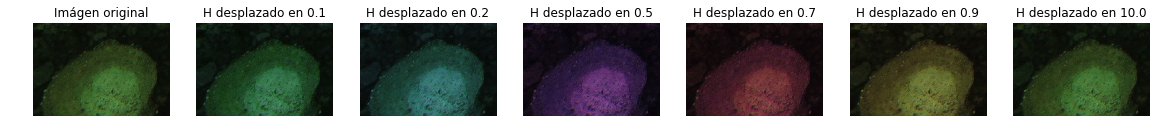

In [20]:
img = imageio.imread("../img/imagenesColor/1892xx.png")[:,:,(0,1,2)] / 255
img = colors.rgb_to_hsv(img)
differentCValues = [.1, .2, .5 , .7, .9, 10]

fig, ax = plt.subplots(nrows=1, ncols=1 + len(differentCValues), figsize=(20,20))

def displaceHueWithCircularArithmetic(img, c):
    """
        Displace the hue channel in an image img, whose color space is HSV.
    """
    imageWithHueDisplaced = img.copy()
    imageWithHueDisplaced[..., 0] = np.remainder(imageWithHueDisplaced[..., 0] + c, 1)
    return imageWithHueDisplaced

show(ax[0], colors.hsv_to_rgb(img), title="Imágen original")
for i, c in enumerate(differentCValues):
    imageWithHueDisplaced = displaceHueWithCircularArithmetic(img, c)
    # print("Min: %.2f     Min: %.2f" % (np.amin(imageWithHueDisplaced[:, :, 0]), np.amax(imageWithHueDisplaced[:, :, 0])))
    show(ax[i+1], colors.hsv_to_rgb(imageWithHueDisplaced), title="H desplazado en %.1f" % (c))

Es intresante notar como al agregar la *arimética cirular* al desplazamiento aplicado en el canal de Hue de cada imágen, se puede visualizar la *circularidad* del espacio, pudiendo compremenderlo más facilmente como un ángulo.

### 3) Observaciones

#### a) Ver en cuál de los canales son más visibles los detalles y en cuáles es más distinguible un granulado en una imagen.

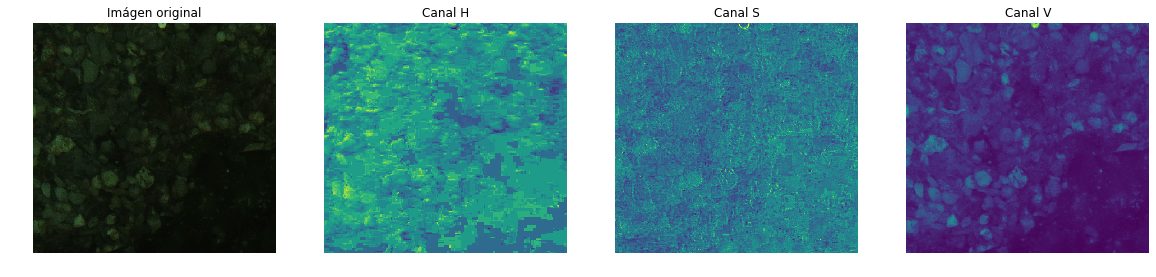

In [21]:
img = imageio.imread("../img/imagenesColor/1892xxx.png")[:, :, (0,1,2)]
imgToHSV = colors.rgb_to_hsv(img)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,20))

show(ax[0], img, title="Imágen original")
show(ax[1], imgToHSV[..., 0], title="Canal H")
show(ax[2], imgToHSV[..., 1], title="Canal S")
show(ax[3], imgToHSV[..., 2], title="Canal V")

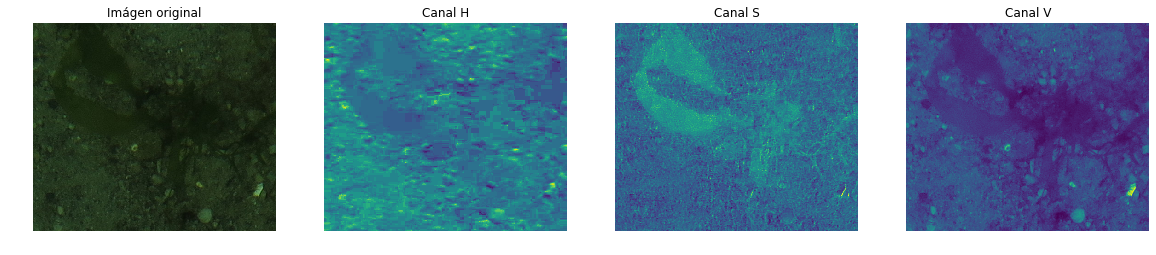

In [22]:
img = imageio.imread("../img/imagenesColor/1906bxx.png")[:, :, (0,1,2)]
imgToHSV = colors.rgb_to_hsv(img)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,20))

show(ax[0], img, title="Imágen original")
show(ax[1], imgToHSV[..., 0], title="Canal H")
show(ax[2], imgToHSV[..., 1], title="Canal S")
show(ax[3], imgToHSV[..., 2], title="Canal V")

En cada una de las imágenes anteriores, las cuales se caracterizan por tener cierto granulado, se puede ver que el canal que *menos* conserva dicha geometría es el S. Por otro lado, el canal H mantiene en parte las caracterísitcas, pero las *difumina* un pocom posiblemente debido al cambio de cromaticidad en los bordes del grandulado.

El canal que *más notorio* hace dicho granulado es el V, pero es necesario aclarar que no mejora mucho la visibilidad del mismo contra el RGB. Por esto, el espacio de colores HSV puede no resultar de mucha utilidad para diferencias este tipo de características.

#### b) Ver a cuál de los canales afectan más los bordes difuminados.

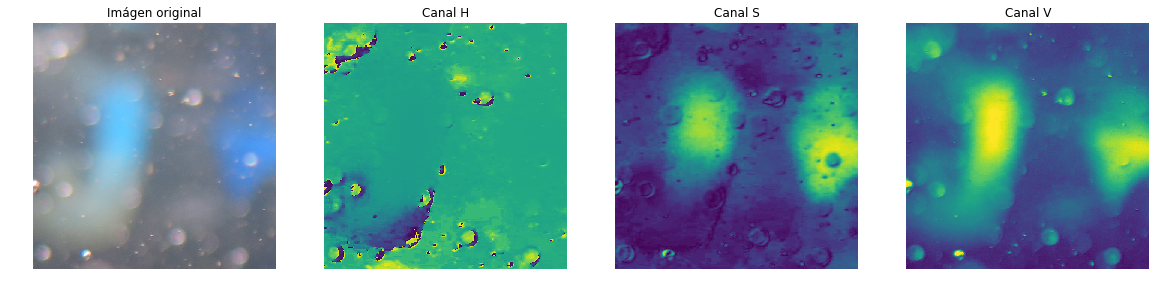

In [23]:
img = imageio.imread("../img/imagenesColor/1923xx.png")[:, :, (0,1,2)]
imgToHSV = colors.rgb_to_hsv(img)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,20))

show(ax[0], img, title="Imágen original")
show(ax[1], imgToHSV[..., 0], title="Canal H")
show(ax[2], imgToHSV[..., 1], title="Canal S")
show(ax[3], imgToHSV[..., 2], title="Canal V")

En la imágen anterior, caracterizada por tener un difuminado importante, se puede notar que los canales más afectados por el mismo son el S y el V, ya que en estos se puede notar que dentro de la mimsa región de un color partiuclar (caracterizado por un rango acotado en el canal H), se produce una variación en la saturación o la luminosidad del mismo. 

Es interesante ver como en el canal H es casi imperceptible el difuminado.

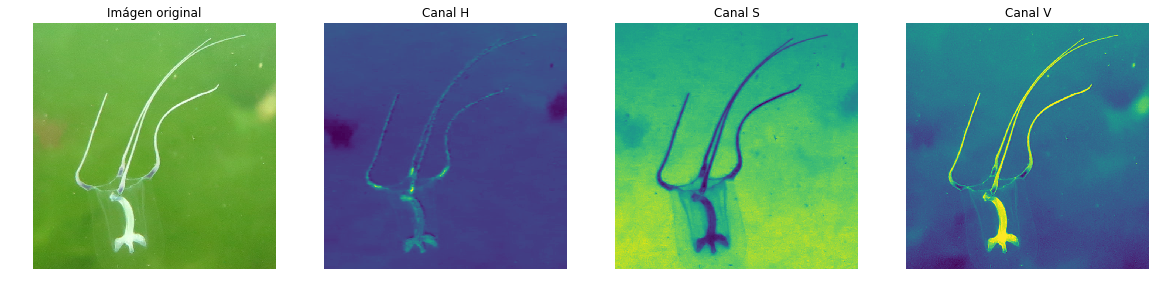

In [24]:
img = imageio.imread("../img/imagenesColor/1901xx.png")[:, :, (0,1,2)]
imgToHSV = colors.rgb_to_hsv(img)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,20))

show(ax[0], img, title="Imágen original")
show(ax[1], imgToHSV[..., 0], title="Canal H")
show(ax[2], imgToHSV[..., 1], title="Canal S")
show(ax[3], imgToHSV[..., 2], title="Canal V")

De igual manera en esta imágen es más notorio el difuminado en la capa transparente del animal en el canal S, siendo casi imperceptible en el H.